# Loading Image Data

So far we've been working with fairly artificial datasets that you wouldn't typically be using in real projects. Instead, you'll likely be dealing with full-sized images like you'd get from smart phone cameras. In this notebook, we'll look at how to load images and use them to train neural networks.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle.

We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

The easiest way to load image data is with `datasets.ImageFolder` from `torchvision` ([documentation](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder)). In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

where `'path/to/data'` is the file path to the data directory and `transform` is a list of pre-processing steps built with the transforms ([documentation](https://pytorch.org/vision/stable/transforms.html)) module from `torchvision`. ImageFolder expects the files and directories to be constructed like so:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has its own directory (`cat` and `dog`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `cat`. You can download the dataset already structured like this [from here](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip). I've also split it into a training set and test set.

### Transforms

When you load the data with `ImageFolder`, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with `transforms.Resize()` or crop with `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`, etc. We'll also need to convert the images to PyTorch tensors with `transforms.ToTensor()`. Typically you'll combine these transforms into a pipeline with `transforms.Compose()`, which accepts a list of transforms and runs them in sequence. It looks something like to scale, then crop, then convert to a tensor:

```python
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

```

### Data Loaders

With the `ImageFolder` loaded, you have to pass it to a `DataLoader` ([documentation](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader)). The `DataLoader` takes a dataset (such as you would get from `ImageFolder`) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch. 

**Why shuffling the data?**

By shuffling the rows and training on only a subset of them during a given epoch, the data changes with every epoch, And therefore, this can prevent the solver from getting stuck in a local minimum ([For more information](https://datascience.stackexchange.com/questions/24511/why-should-the-data-be-shuffled-for-machine-learning-tasks)).

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

Here `dataloader` is a generator. To get data out of it, you need to loop through it or convert it to an iterator and call `next()`.

```python
# Looping through it, get a batch on each loop 
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))
```
 
>**Exercise:** Load images from the `Cat_Dog_data/train` folder, define a few transforms, then build the dataloader.

We will load the data from the URL and save in Collab

In [ ]:
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip

--2021-07-29 13:08:26--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.172.8
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.172.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  67.7MB/s    in 8.9s    

2021-07-29 13:08:35 (62.2 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [ ]:
import os
import zipfile

local_zip = 'Cat_Dog_data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [ ]:
data_dir = 'Cat_Dog_data/train'

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.Grayscale(), 
                                transforms.ToTensor()])

dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

(-0.5, 223.5, 223.5, -0.5)

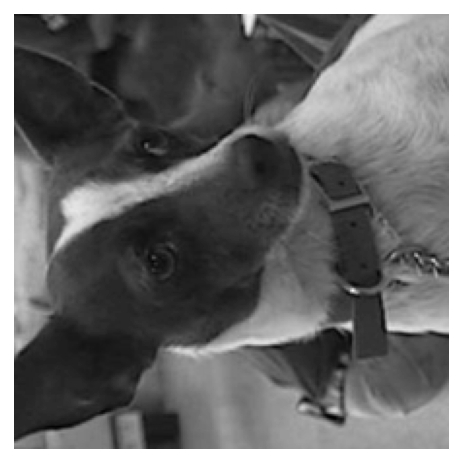

In [ ]:
images, labels = next(iter(dataloader))
plt.imshow(images[0].numpy().transpose((2, 1, 0))[:,:,0], 'gray')
plt.axis('off')

## Data Augmentation

A common strategy for training neural networks is to introduce randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc.

To randomly rotate, scale and crop, then flip your images you would define your transforms like this:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
```

You'll also typically want to normalize images with `transforms.Normalize`. You pass in a list of means and list of standard deviations, then the color channels are normalized like so

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Subtracting `mean` centers the data around zero and dividing by `std` squishes the values to be between -1 and 1. Normalizing helps keep the network work weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

You can find a list of all [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html). **When you're testing however, you'll want to use images that aren't altered (except you'll need to normalize the same way). So, for validation/test images, you'll typically just resize and crop**.

>**Exercise:** Define transforms for training data and testing data below. Leave off normalization for now.

In [ ]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(45),
                                      transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor()])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

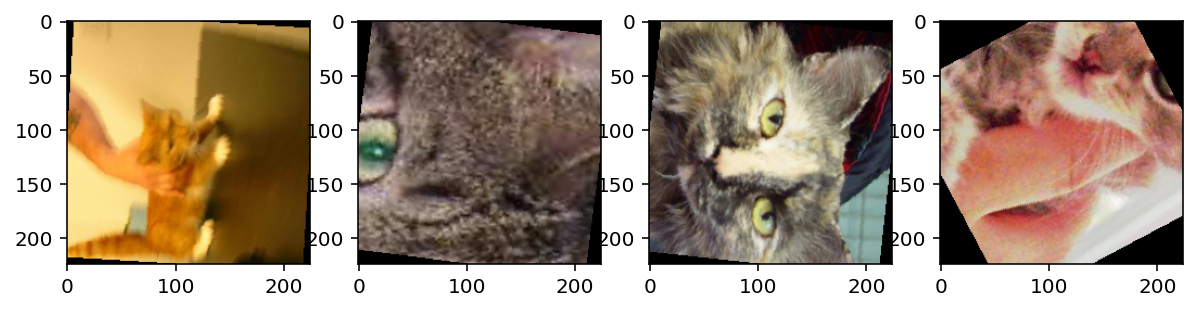

In [ ]:
# For training
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    ax.imshow(images[ii].numpy().transpose((2, 1, 0)))

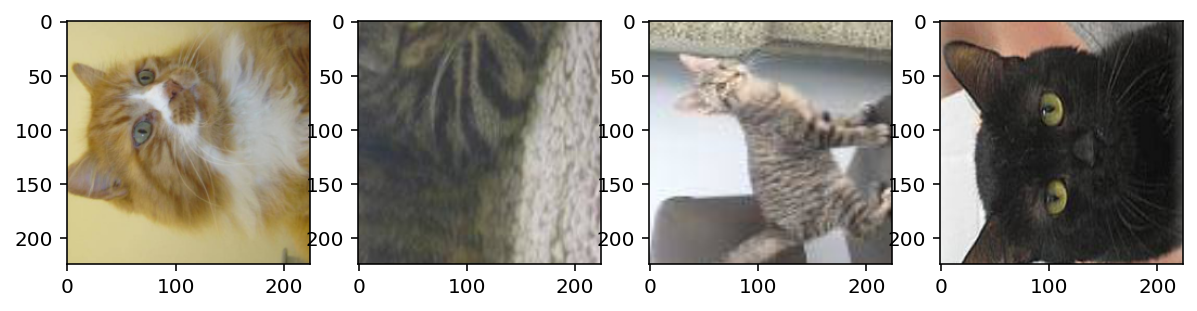

In [ ]:
# For Testing
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    ax.imshow(images[ii].numpy().transpose((2, 1, 0)), 'gray')

At this point you should be able to load data for training and testing. Now, you should try building a network that can classify cats vs dogs. This is quite a bit more complicated than before with the MNIST and Fashion-MNIST datasets. To be honest, you probably won't get it to work with a fully-connected network, no matter how deep. These images have three color channels and at a higher resolution (so far you've seen 28x28 images which are tiny).

In the next part, I'll show you how to use a pre-trained network to build a model that can actually solve this problem.

In [ ]:
data_dir = 'Cat_Dog_data'

train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.Grayscale(),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.Grayscale(),
                                       transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
from fc_model import Network, train
import torch
from torch import nn, optim
import torch.nn.functional as F

In [ ]:
model = Network(224*224, 2, [256, 128, 64, 10])
model

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=50176, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
  (output): Linear(in_features=10, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
train(model, trainloader, testloader, criterion, optimizer, epochs=5)

Epoch: 1/5 ---  Training Loss: 0.7216223800046877 ---  Validation Loss: 0.6932679370045662 ---  Validation Accuracy: 49.4140625%
Epoch: 2/5 ---  Training Loss: 0.693817349658771 ---  Validation Loss: 0.6930788114666939 ---  Validation Accuracy: 50.5859375%
Epoch: 3/5 ---  Training Loss: 0.6934444062750448 ---  Validation Loss: 0.6931888923048973 ---  Validation Accuracy: 50.0%
Epoch: 4/5 ---  Training Loss: 0.6935429567979141 ---  Validation Loss: 0.693154925107956 ---  Validation Accuracy: 49.4140625%
Epoch: 5/5 ---  Training Loss: 0.693472819910808 ---  Validation Loss: 0.6931297346949578 ---  Validation Accuracy: 50.5859375%
